**<font color='red'> Warning:</font> Make sure this file is named HMMInference.ipynb on Coursera or the submit button will not work.**

*If you plan to run the assignment locally:*
You can download the assignments and run them locally, but please be aware that as much as we would like our code to be universal, computer platform differences may lead to incorrectly reported errors even on correct solutions. Therefore, we encourage you to validate your solution in Coursera whenever this may be happening. If you decide to run the assignment locally, please: 
   1. Try to download the necessary data files from your home directory one at a time,
   2. Don't update anything other than this Jupyter notebook back to Coursera's servers, and 
   3. Make sure this notebook maintains its original name after you upload it back to Coursera.
   
Note: You need to submit the assignment to be graded, and passing the validation button's test does not grade the assignment. The validation button's functionality is exactly the same as running all cells.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from hmmlearn.hmm import MultinomialHMM
from matplotlib import pyplot as plt
import seaborn as sns

from aml_utils import test_case_checker, perform_computation

# *Assignment Summary

This is an exercise that implements HMMs (Section 13.2 from the textbook). For this excercise you will use the `hmmlearn` library.

In this excercise we will use HMMs to denoise a sequence of hidden states for an autonomous driving system. The data consists on readings of an observed variable corresponding to a label of three types of pavement markings (shoulder marking, center pavement marking, left pavement marking) which we will denote with 0,1,2. There are two hidden states which describe whether a car is centered or not (0,1). The autonomous driving is equipped with a computer vision (CV) system that estimates the hidden state, however, due to several limitations associated to weather, cleanliness of the sensor, and other environmental factors, the readings are noisy and biases the readings to match previously read data. Thus, you are in charge of creating a denoising system such that the estimation of the hidden state may be more realistic. In summary, the data has two columns: `markings` which is the visible label of pavement markings directy gathered with the sensors and that you will use to train the models, and `centered` which is a reference hidden state that is not directly captured by the sensors but is estimated with a CV system. For the sake of simplicity we will not have a separated training and test set.

Build the function to compute the cost function of the best path leaving each node at a given iteration of the dynamic programming process (for a given column of the trellis), and also the path. For the sake of simplicity you are given the dynamic programming procedure. You only need to program the computation of the cost function and the identification of the best cost and the index of the best cost. Thus, for the function currentWeightBestPath, you should report (a) the cost (sum of log probabilities) and (b) the index (argument) that optimizes the cost.

Notice that the cost function is given by the negative sum of log probabilities:

$C_w(j) = \min_u\left[−\log P(X_{w+1} = u|X_w = j) −\log P(Y_{w+1}|X_{w+1} = u)−C_{w+1}(u)\right]$

$B_w(j) = \arg\min_u\left[−\log P(X_{w+1} = u|X_w = j) −\log P(Y_{w+1}|X_{w+1} = u)−C_{w+1}(u)\right]$


This is equivalent to maximize the sum of log probabilities:

$C_w(j) = \max_u\left[\log P(X_{w+1} = u|X_w = j) +\log P(Y_{w+1}|X_{w+1} = u)+C_{w+1}(u)\right]$
$B_w(j) = \arg\max_u\left[\log P(X_{w+1} = u|X_w = j) +\log P(Y_{w+1}|X_{w+1} = u)+C_{w+1}(u)\right]$

More details of this implementation are provided below.


<font color='red'> <b>Attention:</b> </font> After finishing this notebook, you will need to do a follow-up quiz as well. The overall grade for this asiggnment is based on this notebook and the follow-up quiz.
    
<font color='red'><b> Warning: </b></font> Using the "Validate" button for this assignment may lead to a timeout, please do not use it.

# 0. Data

## 0.1 Description

We'll use a synthetic dataset for this excercise. It consists of a single table with two columns. The `markings` is the visible column corresponds to the observed state of the sequence. The `centered` column is the hidden sequence of states which are a noisy estimate of the hidden state that will be used for comparison purposes.

## 0.2 Loading the Data

In [2]:
# Let's extract the data

data = pd.read_csv('../HMMInference-lib/data.csv')
V = data['Markings'].values
 

## 0.3 Creating a default set of transition and emision probability matrices and training the HMM

In [3]:
# Transition Probability Matrix
transition_p = np.ones((2, 2))
transition_p = transition_p / np.sum(transition_p, axis=1)
 
# Emission Probability Matrix
emission_p = np.array(((1, 3, 5), (2, 4, 6)))
emission_p = emission_p / np.sum(emission_p, axis=1).reshape((-1, 1))
 
initial_distribution = np.array((0.5, 0.5))
 

print(transition_p)
print(emission_p)
print(initial_distribution)

np.random.seed(37)
model = MultinomialHMM(n_components=2,  n_iter=10000).fit(np.reshape(V,[len(V),1]))


print(model.n_features)
print(model.emissionprob_)
print(model.transmat_)

[[0.5 0.5]
 [0.5 0.5]]
[[0.11111111 0.33333333 0.55555556]
 [0.16666667 0.33333333 0.5       ]]
[0.5 0.5]
3
[[0.29555524 0.35177783 0.35266694]
 [0.09060737 0.16462862 0.74476401]]
[[0.88660295 0.11339705]
 [0.14367922 0.85632078]]


# <span style="color:blue">Task 1</span>



Create a python function to compute the cost of the best path leaving each node at a given iteration of the dynamic programming process (for a given column of the trellis), and also the path. For the sake of simplicity you are given the dynamic programming procedure. You only need to program the computation of the cost function and the identification of the best cost and the index of the best cost. Thus, for the function currentWeightBestPath, you should report (a) the cost (sum of log probabilities) and (b) the index (argument) that optimizes the cost.

For the sake of simplicity you can maximize the sum of log probabilities using the formula:

$C_w(j) = \max_u\left[\log P(X_{w+1} = u|X_w = j) +\log P(Y_{w+1}|X_{w+1} = u)+C_{w+1}(u)\right]$
$B_w(j) = \arg\max_u\left[\log P(X_{w+1} = u|X_w = j) +\log P(Y_{w+1}|X_{w+1} = u)+C_{w+1}(u)\right]$

Suggestion: build first the sum of log probabilities and use the resulting vector to identify the maximal value of the log probability and the index associated to it:

$\log P(X_{w+1}|X_w) + \log P(Y_{w+1}|X_{w+1}) + C_{w+1}$

The dimension of $\log P(X_{w+1}|X_w)$ and $C_{w+1}$ is equal to the number of states (in this assignment the numver is 2). $\log P(Y_{w+1}|X_{w+1}=u)$ is a single value.

In [8]:
def currentWeightBestPath(logP_X_given_X, logP_Y_given_X, Cw1):
    """
    Performs computation of log-probabilities to derive Cw(j) and Bw(j).
    for a specific iteration j

        Parameters:
                logP_X_given_X (np array): Dimension = S (number of states) x 1
                logP_Y_given_X (np array): dimension 1x1.  
                Cw1 (np array): Dimension= number of states x 1. The value of the previous Cw

        Returns:
                u (int): the index with maximum sum of log probabilities among S options
                maxlogprob (double): the maximum sum of log probabilities among S options
    """       
    assert logP_X_given_X.ndim == 1
    assert Cw1.ndim == 1

    assert logP_X_given_X.shape[0]==Cw1.shape[0] #== S

    # your code here
    #raise NotImplementedError
    
    S = logP_X_given_X.shape[0]
    
    # initialize an array to store the sum of log probabilities
    sum_log_probs = np.zeros(S)
    
    # compute the sum of log probabilities for each state
    for u in range(S):
        sum_log_probs[u] = logP_X_given_X[u] + logP_Y_given_X + Cw1[u]
    
    # find the index of the maximum sum of log probabilities
    u = np.argmax(sum_log_probs)
    
    # find the maximum sum of log probabilities
    maxplogrob = sum_log_probs[u]
    
    return u,maxplogrob

In [9]:
#verify correctness of function

index,maxlogp = currentWeightBestPath(np.array([-0.12035803, -1.94017208]), np.array([-1.0447554802085524]), np.array([44.85810916, 49.23474131]))

print(maxlogp)

assert index==1
assert maxlogp==46.24981374979144


print(model.emissionprob_)
print(model.transmat_)

46.24981374979144
[[0.29555524 0.35177783 0.35266694]
 [0.09060737 0.16462862 0.74476401]]
[[0.88660295 0.11339705]
 [0.14367922 0.85632078]]


In [10]:
def viterbi_Modular(V, a, b, initial_distribution):
    """ 
    This function simply applies your cost function to traverse the trellis for identification of the optimal path
    This implementation uses a forward exploration and then backtracks the computed values to find the optimal path.
    """
    T = V.shape[0]
    M = a.shape[0] # or [1]
 
    omega = np.zeros((T, M))
    omega[0, :] = np.log(initial_distribution * b[:, V[0]])
 
    prev = np.zeros((T - 1, M))
 
    for t in range(1, T):
        for j in range(M):
            #transition and emision (transition is associated to X|X since the book uses X to represent the hidden states and emision to Y|X)
            u,maxprob = currentWeightBestPath( np.log(a[:, j]),  np.log(b[j, V[t]]) , omega[t - 1]) 
 
            # The most probable state given previous state for time t:
            prev[t - 1, j] = u #np.argmax(probability)
 
            # The probability of the most probable state at time t:
            omega[t, j] = maxprob #np.max(probability)

 
    # Path initialization
    S = np.zeros(T,dtype=int)
 
    # Find the most probable last hidden state
    last_state = np.argmax(omega[T - 1, :])
 
    S[0] = last_state
 
    backtrack_index = 1
    for i in range(T - 2, -1, -1):
        S[backtrack_index] = prev[i, int(last_state)]
        last_state = prev[i, int(last_state)]
        backtrack_index += 1
 
    # backtrack
    result = np.flip(S, axis=0)
 
    return result

In [11]:
# Let's evaluate the Viterbi algorithm with your cost function implementation using X1
np.random.seed(1)
X1 = np.random.randint(low=0, high=3, size=(15,))

model2=MultinomialHMM(n_components=2,  n_iter=10000).fit(np.reshape(X1,[len(X1),1]))

predicted_hidden_sates = viterbi_Modular(X1, model2.transmat_, model2.emissionprob_, initial_distribution)

assert np.array_equal(predicted_hidden_sates,  np.array([0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1]))

print(predicted_hidden_sates)


[0 1 1 0 0 1 1 0 1 0 1 1 0 1 1]


In [12]:

predicted_sequence = viterbi_Modular(V, model.transmat_, model.emissionprob_, initial_distribution)

print(predicted_sequence)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

# <span style="color:blue">Task 2</span>


Implement the HMM sequence using the `predict` funtion of `hmmlearn`. For this you need to make sure the sequence (which is stored in the variable `V`) is formatted as a column vector (one column).

The function `predict` is a property of the model's object. Your implementation uses as parameters the `model` trained in the previous cell and the array of observed values.

In [13]:
def predictSequenceReference(observed_values, model):
    """
    Performs prediction of most likely sequence using the hmmlearn library.

        Parameters:
                observed_values (np array): Observed values
                model (hmmlearn.hmm.MultinomialHMM object): the trained HMM  

        Returns:
                predicted_sequence (np array): the predicted sequence of hidden states
    """       

    # your code here
    #raise NotImplementedError
    
    # ensure observed_values is a column vector
    observed_values = observed_values.reshape(-1, 1)
    
    # Uue the predict function to predict the hidden states for the observed sequence
    predicted_sequence = model.predict(observed_values)
    
    return predicted_sequence



In [14]:
reference_preds=predictSequenceReference(V,model) 

assert np.array_equal( reference_preds[:10], [0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

print(reference_preds)

[0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [15]:
def plotTimeSeries(Q, hidden_states, ylabel, labelvals=('1','2'), printLines=True, xlabel="Sequence", filename = "HMMTseries_img.png"):
    """
    Plots the sequence with hidden_states color-coded
    Based on Pat Reed's example
    """

    sns.set()
    fig = plt.figure()
    ax = fig.add_subplot(111)
 
    xs = np.arange(len(Q))
    masks = hidden_states == 0
    ax.scatter(xs[masks], Q[masks], c='r', label=labelvals[0])
    masks = hidden_states == 1
    ax.scatter(xs[masks], Q[masks], c='b', label=labelvals[1])
    if printLines:
      ax.plot(xs, Q, c='k')
     
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    fig.subplots_adjust(bottom=0.2)
    handles, labels = plt.gca().get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=2, frameon=True)

 
    return None

# <span style="color:blue">Task 3</span>


Use the ground truth sequence to format the noisy ground truth, i.e., to replace a value of 0 instead of "centered" and a value of 1 instead of "out"


In [16]:
def formatNoisySequence(noisy_sequence):
    """
    uses a numeric formatting of the original noisy sequence.

        Parameters:
                noisy_sequence (np array): Sequence with elements in {'centered', 'out'}
        Returns:
                formatted_noisy_sequence (np array): the numeric version of the original sequence
    """       

    # your code here
    #raise NotImplementedError
    
    # create a mapping from the string values to numeric values
    mapping = {'centered': 0, 'out': 1}
    
    # use the mapping to convert the noisy sequence to a numeric sequence
    formatted_noisy_sequence = np.array([mapping[element] for element in noisy_sequence])
    
    
    return formatted_noisy_sequence

In [17]:
gtValues=formatNoisySequence(data['CenteredNoisy'].values) 

assert np.array_equal( gtValues[np.concatenate(([0,23,46,65,70], range(81,100)),axis=None)], 
                      [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,1, 1])

gtValues

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,

Comparison of Labels in the Sequence.
(Notice that the HMM leads to more stable hidden label esimation than the noisy ground truth)


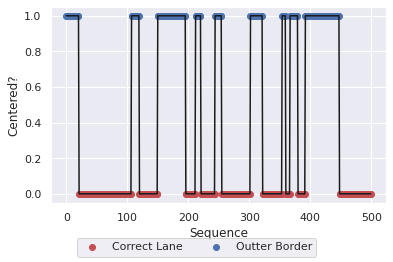

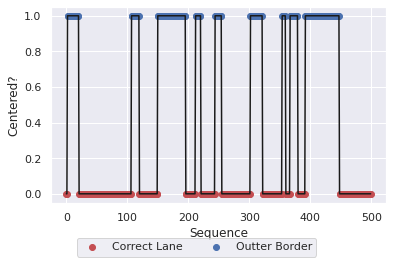

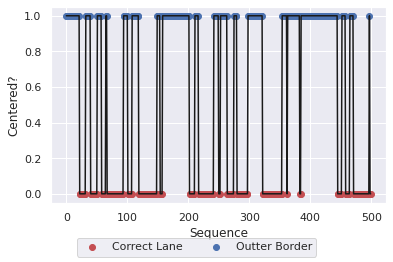

In [18]:
print("Comparison of Labels in the Sequence.\n(Notice that the HMM leads to more stable hidden label esimation than the noisy ground truth)")

valueTest=np.reshape(predicted_sequence,[len(V),1])
plotTimeSeries(valueTest, predicted_sequence, 'Centered?', ("Correct Lane","Outter Border"))

valueTest=np.reshape(reference_preds,[len(V),1])
plotTimeSeries(valueTest, reference_preds, 'Centered?', ("Correct Lane","Outter Border"))

valueTest=np.reshape(gtValues,[len(V),1])
plotTimeSeries(valueTest, gtValues, 'Centered?', ("Correct Lane","Outter Border"))


Comparison of Labels per Observed State.
(Notice that the HMM leads to more stable hidden label esimation than the noisy ground truth)


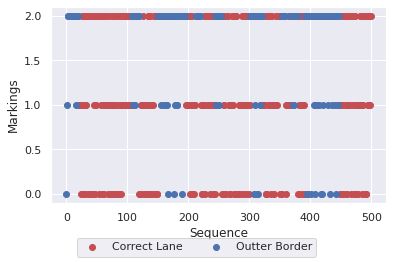

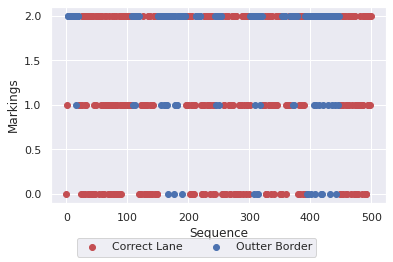

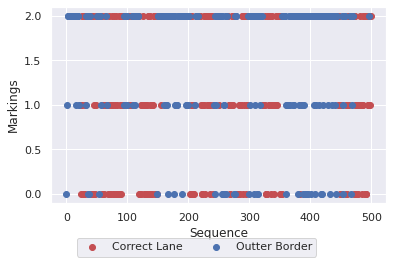

In [19]:
print("Comparison of Labels per Observed State.\n(Notice that the HMM leads to more stable hidden label esimation than the noisy ground truth)")

valueTest=np.reshape(V,[len(V),1])
plotTimeSeries(valueTest, predicted_sequence, 'Markings', ("Correct Lane","Outter Border"),False)

plotTimeSeries(valueTest, reference_preds, 'Markings', ("Correct Lane","Outter Border"),False)

plotTimeSeries(valueTest, gtValues, 'Markings', ("Correct Lane","Outter Border"),False)


# <span style="color:blue">Task 4</span>

Compute the MSE and MAE of the predicted label. While it is not always straighforward to see, an objective of using HMM for data denoising is also minimizing the difference from the noisy states with the objective of maintaining a close resemblance to the expected sequence.

To evaluate your implementation of HMM with respect to a previously assign "ground truth" you will implement the mean squared error and mean absolute error of the predicted sequence vs. the "real" but noisy sequence. 




In [20]:
def computeErrors(predictions, realvalues):
    """
    Performs computation of MSE and MAE of the predicted sequence vs. the real sequence

        Parameters:
                predictions (np array): Dimension = N x 1
                realvalues (np array): Dimension = Nx1  

        Returns:
                MSE (double): the Mean Squared Error
                MAE (double): the Mean Absolute Error
    """       
    assert predictions.shape[0]==realvalues.shape[0] #== S

    # your code here
    #raise NotImplementedError
    
    # compute the Mean Squared Error (MSE)
    mse = np.mean((predictions - realvalues) ** 2)
    
    # compute the Mean Absolute Error (MAE)
    mae = np.mean(np.abs(predictions - realvalues))    
    
    return mse,mae

In [21]:
refmse,refmae = computeErrors(reference_preds,gtValues)

mse,mae = computeErrors(predicted_sequence,gtValues)

print("Errors for your solution: mse: %f, mae: %f" % ( mse,mae) )

print("Errors for reference solution: mse: %f, mae: %f" % (refmse,refmae))

assert refmse < 2
assert refmae < 0.5
assert mse < 2
assert mae < 0.5

Errors for your solution: mse: 0.196000, mae: 0.196000
Errors for reference solution: mse: 0.200000, mae: 0.200000
